In [27]:
#loading packages

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns 


from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
#set squared parameter equal to false for RMSE
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet
from scipy import stats
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.ensemble import IsolationForest

## [Final Dataset can be found here](https://docs.google.com/spreadsheets/d/1N48rTeq7md0v8w8pG_8XIiuapPHQAeO5WoWIB3eaceI/edit#gid=14493513773) 

### Importing dataset 

In [28]:
#importing dataset
Final_Data = pd.read_csv("FinalDataset_2022_Update.csv")


In [29]:
#initial look 
Final_Data.head()

,study_id,year,quarter,region,country,pa,channel,tactic,conversion,study_name,...,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,duration,Significant_Spend
0,1988435,2021,Q3,AMER,US,Project Fi,YOUTUBE,Mixture (not all channel),Type 330755641 (Google Fi - New Microsite - Si...,25036259 | 11136 | Google Fi | NA | EN | NA | ...,...,17627166,4647.000000,2013.000000,2.309029,1.599459e+06,1805.000000,0.388347,1.0000,56,1
1,1988435,2021,Q4,AMER,US,Project Fi,YOUTUBE,Mixture (not all channel),Type 330755641 (Google Fi - New Microsite - Si...,25036259 | 11136 | Google Fi | NA | EN | NA | ...,...,14059895,3314.000000,1466.000000,2.260194,1.228240e+06,1158.000000,0.349543,1.0000,29,1
2,2451798,2021,Q1,AMER,US,DSM,YOUTUBE,All Channel,Type 519097913 (Global - Google Store - All Pr...,CGstore Q1'21 Home DR Template Video (CL),...,672818,1320.113475,581.363879,2.270718,1.856219e+05,242.205738,3.228902,1.0000,31,1
3,2451801,2021,Q1,AMER,US,Pixel,YOUTUBE,All Channel,Type 519097913 (Global - Google Store - All Pr...,CGstore Q1'21 Mobile Standalone Video (CL),...,658642,1043.362770,453.125573,2.302591,3.314659e+05,38.829515,0.135380,0.7611,31,0
4,2491769,2021,Q1,AMER,US,DSM,YOUTUBE,All Channel,Type 519097913 (Global - Google Store - All Pr...,CGstore Q1'21 Home Lifestyle Video (CL),...,748711,1972.731675,868.639990,2.271058,1.861579e+05,75.545627,0.914772,0.0695,31,0


### Data Prep:
 - Filtering only on Search studies
 - Filtering on studies that don't have 0 exposed
 - Filtering on studies with absolute lift > 0 
 - Creating new region column to differentiate CA + US countries from rest of AMER
 - Creating new tactic column to differentiate BKWS from all other tactics 

In [30]:
#filtering only on search channel
Final_Search_Data = Final_Data[Final_Data["channel"] == "Search"]

#filtering out studies where exposed != 0
Final_Search_Data = Final_Search_Data[Final_Search_Data["exposed"] != 0]

#filtering out studies with negative lift 
Final_Search_Data = Final_Search_Data[Final_Search_Data["absolute_lift"] > 0]

## replacing NA values in country with 'US'
Final_Search_Data.country = Final_Search_Data.country.fillna('US')

## replacing NA values of region depending on country labels to 'AMER'
country_list = ['CA', 'US', 'US + CA', 'BR', 'MX', 'CL',
               'SPLATAM - (AR, CL, CO, MX, PE)',
               'LAC-Others (BO, CR, DO, EC, GT, HN, NI, PA, PR, PY, SV, UY)',
               'LAC-Others (BO, CR, DO, EC, GT, HN, NI, PA, PY)']

Final_Search_Data.loc[Final_Search_Data['country'].isin(country_list), 'region'] = 'AMER'

## creating new tactic column to indicate if it's BKWS and if not then it's AO

Final_Search_Data['tactic_v2'] = np.where(Final_Search_Data['tactic'] == "BKWS", "BKWS", "AO")

## creating new region column to differentiate us+ca from AMER

Final_Search_Data['region_v2'] = np.where(Final_Search_Data['country'].isin(['CA', 'US', 'US + CA']), 'AMER_USCA', Final_Search_Data['region'])

In [31]:
#checking to see if new columns/transformations have been added
Final_Search_Data.head(15)

,study_id,year,quarter,region,country,pa,channel,tactic,conversion,study_name,...,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,duration,Significant_Spend,tactic_v2,region_v2
340,1,2021,Q3,AMER,All,Pixel,Search,All,All Mobile Pseudo Conversions,Google_Store_2020_09_11_10_44_00,...,4640.0,1.000662,64088.36,817.929799,0.176161,1.0,220,1,AO,AMER
341,1,2021,Q3,AMER,US,Pixel,Search,AO,All Mobile Pseudo Conversions,Google_Store_2020_09_11_10_44_00,...,91.0,1.016673,9123.74,162.482751,1.756243,1.0,220,1,AO,AMER_USCA
342,1,2021,Q3,AMER,US,Pixel,Search,SKWS,All Mobile Pseudo Conversions,Google_Store_2020_09_11_10_44_00,...,4549.0,0.996782,54964.62,671.640054,0.148122,1.0,220,1,AO,AMER_USCA
343,2,2021,Q1,AO,All,Chrome,Search,All,Desktop Downloads,Google_Chrome_2021-02-08_2021-02-22_02-05-08,...,86785.0,69.722587,776083.90,594478.286900,0.098247,1.0,88,1,AO,AO
344,2,2021,Q1,AMER,AR,Chrome,Search,AO,Desktop Downloads,Google_Chrome_2021-02-08_2021-02-22_02-05-08,...,1624.0,68.914518,4097.05,16168.822250,0.144471,1.0,88,1,AO,AMER
345,2,2021,Q1,AMER,BR,Chrome,Search,AO,Desktop Downloads,Google_Chrome_2021-02-08_2021-02-22_02-05-08,...,58.0,67.465026,2711.34,3446.028497,0.880668,1.0,88,1,AO,AMER
347,2,2021,Q1,AMER,CL,Chrome,Search,AO,Desktop Downloads,Google_Chrome_2021-02-08_2021-02-22_02-05-08,...,1151.0,68.521319,2363.52,8615.961910,0.109245,1.0,88,1,AO,AMER
348,2,2021,Q1,AMER,CO,Chrome,Search,AO,Desktop Downloads,Google_Chrome_2021-02-08_2021-02-22_02-05-08,...,593.0,73.279961,2471.90,9561.983301,0.220043,1.0,88,1,AO,AMER
349,2,2021,Q1,EMEA,ES,Chrome,Search,AO,Desktop Downloads,Google_Chrome_2021-02-08_2021-02-22_02-05-08,...,446.0,67.889474,2552.22,3697.294737,0.122109,1.0,88,1,AO,EMEA
350,2,2021,Q1,EMEA,GB,Chrome,Search,AO,Desktop Downloads,Google_Chrome_2021-02-08_2021-02-22_02-05-08,...,235.0,67.942029,5233.99,1053.623188,0.065990,1.0,88,1,AO,EMEA


### Separating Chrome from Non-Chrome data

In [72]:
#separating chrome from non-chrome data and filtering out topline results 

Chrome = Final_Search_Data.loc[(Final_Search_Data['pa'] == "Chrome") & (Final_Search_Data['tactic'] != "All")]
Non_Chrome = Final_Search_Data.loc[(Final_Search_Data['pa'] != "Chrome") & (Final_Search_Data['tactic'] != "All")]

In [73]:
#checking data count 
print(len(Chrome))
print(len(Non_Chrome))

87
60


## Complete Search EDA can be found [here](https://drive.google.com/file/d/1S1BAHIKdy_eqk_bJL2fCYe66Sr0UirI2/view?usp=sharing)

Includes:
- Overall data count for Chrome and Non-Chrome
- Boxplot relationships of absolute lift and total spend separated by regions, pa's, tactics and quarter
- Kruskall-Wallis & Pairwise-Wilcox Findings to determine groupings of pa's, regions and tactics to be used in building out the response curves in this notebook 


## Functions for Regression Models

In [74]:
#HuborRegressor
def Hubor_Regressor(dataset, powers, pa_split):
    
    #creating dictionaries to store rmse and r squared scores for each model 
    rmse_scores = {}
    r2_scores = {}
    fig_count = 1
    
    #looping across powers 
    for i in powers:
        
        
        x = dataset['cost_spent_on_exposed_group']
        y = dataset['absolute_lift']
    
        #need to reshape x and y
        x = np.array(x).reshape(-1,1)
        y = np.ravel(np.array(y).reshape(-1,1))

        #initializing model
        hr = HuberRegressor()
        hr.fit(x**i,y)
        pred_train_hr = hr.predict(x**i)
        rmse_scores[i] = np.sqrt(mean_squared_error(y,pred_train_hr))
        r2_scores[i] = r2_score(y, pred_train_hr)
        
        #sorting x and y values for line plot 
        #x_plot, y_plot = zip(*sorted(zip(x, pred_train_hr)))
        
        #code to smoothen line 
        #xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
        #define spline
        #spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
        #y_smooth = spl(xnew)

        #plotting fitted values against real values and saving to folder 
        #fig = plt.figure(figsize = (12,8))
        #plt.scatter(x,y)
        #plt.plot(xnew,y_smooth, c = 'r')
        #plt.title(pa_split + ' HuberRegressor Modeling', fontsize=16)
        #plt.xlabel('Cost Spent on Exposed Group ^ ' + str(i))
        #plt.ylabel('Absolute Lift')
        #plt.savefig('HR Curves/{} {}.png'.format(pa_split,fig_count))
        #plt.close(fig)
        #fig_count += 1
    
    #extracting power that resulted in best rmse score 
    best_power = min(rmse_scores.items())[0]
    
    #repeating same steps from the loop but only on best_power and showing plotted curve
    x = dataset['cost_spent_on_exposed_group']
    y = dataset['absolute_lift']
    
    x = np.array(x).reshape(-1,1)
    y = np.ravel(np.array(y).reshape(-1,1))
    
    best_hr = HuberRegressor() 
    best_hr.fit(x**best_power, y)
    pred_train_hr = best_hr.predict(x**best_power)
    
    x_plot, y_plot = zip(*sorted(zip(x, pred_train_hr)))
        
    xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
    spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
    y_smooth = spl(xnew)
    
    fig = plt.figure(figsize = (12,8))
    plt.scatter(x,y)
    plt.plot(xnew,y_smooth, c = 'r')
    plt.title(pa_split + ' HuberRegressor Modeling', fontsize=16)
    plt.xlabel('Cost Spent on Exposed Group ^ ' + str(best_power))
    plt.ylabel('Absolute Lift')
    plt.show()
    
    return min(rmse_scores.items(), key=lambda x: x[1]), max(r2_scores.items(), key=lambda x: x[1])

In [75]:
#Ridge
def ridge_regression(dataset, powers, pa_split, alpha):

    rmse_scores = {}
    r2_scores = {}
    fig_count = 1
    
    for i in powers:
        
        x = dataset['cost_spent_on_exposed_group']
        y = dataset['absolute_lift']
    
        #need to reshape x and y
        x = np.array(x).reshape(-1,1)
        y = np.array(y).reshape(-1,1)
    
        
        #initializing model
        ridge = Ridge(alpha = alpha)
        ridge.fit(x**i,y)
        pred_train_ridge = ridge.predict(x**i)
        rmse_scores[i] = np.sqrt(mean_squared_error(y, pred_train_ridge))
        r2_scores[i] = r2_score(y, pred_train_ridge)
        
        #sorting x and y values for line plot 
        #x_plot, y_plot = zip(*sorted(zip(x, pred_train_ridge)))
        
        #code to smoothen line 
        #xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
        #define spline
        #spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
        #y_smooth = spl(xnew)

        #plotting fitted values against real values
        #fig = plt.figure(figsize = (12,8))
        #plt.scatter(x,y)
        #plt.plot(xnew,y_smooth, c = 'r')
        #plt.title(pa_split + ' Ridge Regression', fontsize=16)
        #plt.xlabel('Cost Spent on Exposed Group ^ ' + str(i))
        #plt.ylabel('Absolute Lift')
        #plt.savefig('Ridge Curves/{} {}.png'.format(pa_split,fig_count))
        #plt.close(fig)
        #fig_count += 1
    
    #extracting power that resulted in best rmse score 
    best_power = min(rmse_scores.items())[0]
    
    #repeating same steps from the loop but only on best_power and showing plotted curve
    x = dataset['cost_spent_on_exposed_group']
    y = dataset['absolute_lift']
    
    x = np.array(x).reshape(-1,1)
    y = np.ravel(np.array(y).reshape(-1,1))
    
    best_ridge = Ridge(alpha=alpha) 
    best_ridge.fit(x**best_power, y)
    pred_train_ridge = best_ridge.predict(x**best_power)
    
    x_plot, y_plot = zip(*sorted(zip(x, pred_train_ridge)))
        
    xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
    spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
    y_smooth = spl(xnew)
    
    fig = plt.figure(figsize = (12,8))
    plt.scatter(x,y)
    plt.plot(xnew,y_smooth, c = 'r')
    plt.title(pa_split + ' Ridge Modeling', fontsize=16)
    plt.xlabel('Cost Spent on Exposed Group ^ ' + str(best_power))
    plt.ylabel('Absolute Lift')
    plt.show()
    
    return min(rmse_scores.items(), key=lambda x: x[1]), max(r2_scores.items(), key=lambda x: x[1])

In [76]:
#Lasso
def lasso_regression(dataset, powers, pa_split, alpha):

    rmse_scores = {}
    r2_scores = {}
    fig_count = 1
    
    for i in powers:
        
        x = dataset['cost_spent_on_exposed_group']
        y = dataset['absolute_lift']
    
        #need to reshape x and y
        x = np.array(x).reshape(-1,1)
        y = np.array(y).reshape(-1,1)
        

        #initializing model
        lasso = Lasso(alpha = alpha)
        lasso.fit(x**i,y)
        pred_train_lasso = lasso.predict(x**i)
        rmse_scores[i] = np.sqrt(mean_squared_error(y, pred_train_lasso))
        r2_scores[i] = r2_score(y, pred_train_lasso)
        
        #sorting x and y values for line plot 
        #x_plot, y_plot = zip(*sorted(zip(x, pred_train_lasso)))
        
        #code to smoothen line 
        #xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
        #define spline
        #spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
        #y_smooth = spl(xnew)

        
        #plotting fitted values against real values 
        #fig = plt.figure(figsize = (12,8))
        #plt.scatter(x,y)
        #plt.plot(xnew,y_smooth,c = 'r')
        #plt.title(pa_split + ' Lasso Regression', fontsize=16)
        #plt.xlabel('Cost Spent on Exposed Group ^ ' + str(i))
        #plt.ylabel('Absolute Lift')
        #plt.savefig('Lasso Curves/{} {}.png'.format(pa_split,fig_count))
        #plt.close(fig)
        #fig_count += 1
        
    #extracting power that resulted in best rmse score 
    best_power = min(rmse_scores.items())[0]
    
    #repeating same steps from the loop but only on best_power and showing plotted curve
    x = dataset['cost_spent_on_exposed_group']
    y = dataset['absolute_lift']
    
    x = np.array(x).reshape(-1,1)
    y = np.ravel(np.array(y).reshape(-1,1))
    
    best_lasso = Lasso(alpha=alpha) 
    best_lasso.fit(x**best_power, y)
    pred_train_lasso = best_lasso.predict(x**best_power)
    
    x_plot, y_plot = zip(*sorted(zip(x, pred_train_lasso)))
        
    xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
    spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
    y_smooth = spl(xnew)
    
    fig = plt.figure(figsize = (12,8))
    plt.scatter(x,y)
    plt.plot(xnew,y_smooth, c = 'r')
    plt.title(pa_split + ' Lasso Modeling', fontsize=16)
    plt.xlabel('Cost Spent on Exposed Group ^ ' + str(best_power))
    plt.ylabel('Absolute Lift')
    plt.show()
    
        
    return min(rmse_scores.items(), key=lambda x: x[1]), max(r2_scores.items(), key=lambda x: x[1])

In [77]:
#ElasticNet
def elastic_net(dataset, powers, pa_split, alpha):
    rmse_scores = {}
    r2_scores = {}
    fig_count = 1
    
    for i in powers:
        
        x = dataset['cost_spent_on_exposed_group']
        y = dataset['absolute_lift']
    
        #need to reshape x and y
        x = np.array(x).reshape(-1,1)
        y = np.array(y).reshape(-1,1)
        

        #initializing model
        ec = ElasticNet(alpha = alpha)
        ec.fit(x**i,y)
        pred_train_ec = ec.predict(x**i)
        rmse_scores[i] = np.sqrt(mean_squared_error(y, pred_train_ec))
        r2_scores[i] = r2_score(y, pred_train_ec)
        
        #sorting x and y values for line plot 
        #x_plot, y_plot = zip(*sorted(zip(x, pred_train_ec)))
        
        #code to smoothen line 
        #xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
        #define spline
        #spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
        #y_smooth = spl(xnew)

        
        #plotting fitted values against real values 
        #fig = plt.figure(figsize = (12,8))
        #plt.scatter(x,y)
        #plt.plot(xnew,y_smooth,c = 'r')
        #plt.title(pa_split + ' ElasticNet Regression', fontsize=16)
        #plt.xlabel('Cost Spent on Exposed Group ^ ' + str(i))
        #plt.ylabel('Absolute Lift')
        #plt.savefig('ElasticNet Curves/{} {}.png'.format(pa_split,fig_count))
        #plt.close(fig)
        #fig_count += 1
        
    #extracting power that resulted in best rmse score 
    best_power = min(rmse_scores.items())[0]
    
    #repeating same steps from the loop but only on best_power and showing plotted curve
    x = dataset['cost_spent_on_exposed_group']
    y = dataset['absolute_lift']
    
    x = np.array(x).reshape(-1,1)
    y = np.ravel(np.array(y).reshape(-1,1))
    
    best_ec = ElasticNet(alpha=alpha) 
    best_ec.fit(x**best_power, y)
    pred_train_ec = best_ec.predict(x**best_power)
    
    x_plot, y_plot = zip(*sorted(zip(x, pred_train_ec)))
        
    xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
    spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
    y_smooth = spl(xnew)
    
    fig = plt.figure(figsize = (12,8))
    plt.scatter(x,y)
    plt.plot(xnew,y_smooth, c = 'r')
    plt.title(pa_split + ' ElasticNet Modeling', fontsize=16)
    plt.xlabel('Cost Spent on Exposed Group ^ ' + str(best_power))
    plt.ylabel('Absolute Lift')
    plt.show()
      
    
    return min(rmse_scores.items(), key=lambda x: x[1]), max(r2_scores.items(), key=lambda x: x[1])

In [78]:
#creating power and alpha lists 
powers = []
for i in np.arange(0.1,0.9,0.01):
    powers.append(i)
    
alphas = []
for i in np.arange(0,1,0.25):
    alphas.append(i)

In [79]:
#What to keep in mind 

###for non chrome and chrome model all regions together 
###for non chrome and chrome model BKWS vs AO tactic separately 
###for non chrome, model all pa's separately except for Pixel and DSM

For each split on PA and Tactic, the resulting plot will be the one that resulted in best RMSE and R-squared scores, with the corresponding power values and RMSE and R squared scores also outputted

All splits were ran on the followng models in the following order:
- Hubor Regressor
- Ridge
- Lasso
- ElasticNet

## Chrome

### Chrome | All Tactic

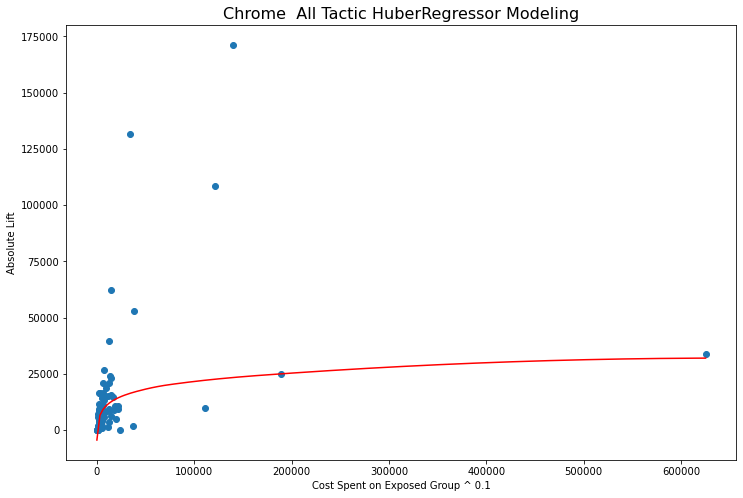

((0.16999999999999998, 23788.96834980943),
 (0.16999999999999998, 0.1706550863003521))

In [80]:
#ROBUST REGRESSION

Hubor_Regressor(dataset = Chrome, powers = powers,  pa_split = 'Chrome  All Tactic')

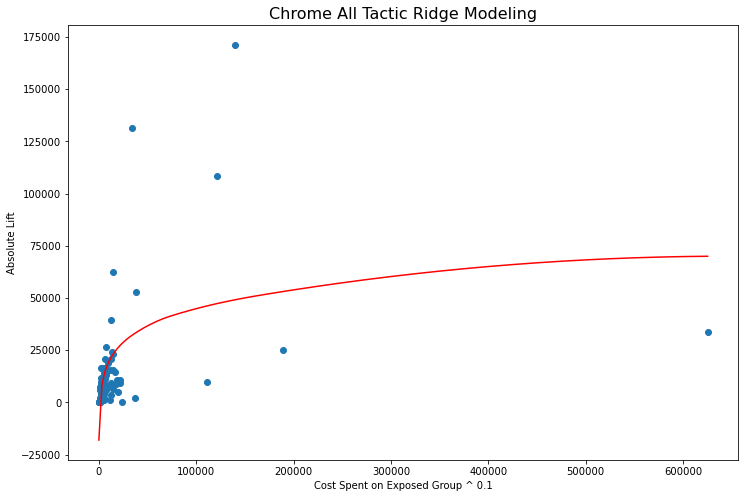

((0.19999999999999996, 21639.86785627334),
 (0.19999999999999996, 0.31373290274345145))

In [81]:
#RIDGE REGRESSION

ridge_regression(dataset = Chrome, powers = powers, pa_split = "Chrome All Tactic", alpha = 0.1)

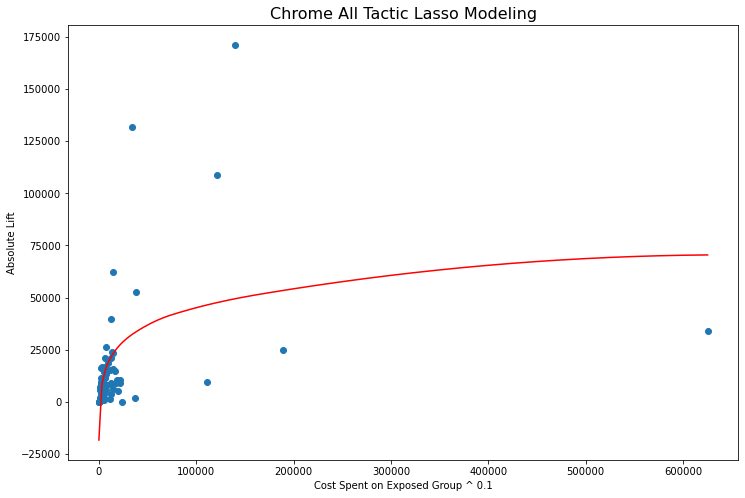

((0.19999999999999996, 21639.86733071898),
 (0.19999999999999996, 0.3137329360773575))

In [82]:
#LASSO REGRESSION

lasso_regression(dataset = Chrome, powers = powers, pa_split = "Chrome All Tactic", alpha = 0.1)

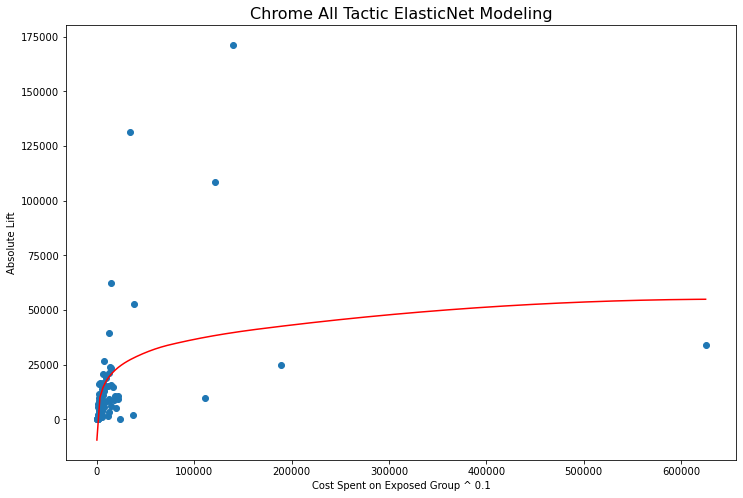

((0.19999999999999996, 21640.835165200984),
 (0.19999999999999996, 0.3136715486602296))

In [83]:
#ELASTICNET REGRESSION

elastic_net(dataset = Chrome, powers = powers, pa_split = "Chrome All Tactic", alpha = 0.1)

### Chrome | BKWS Tactic

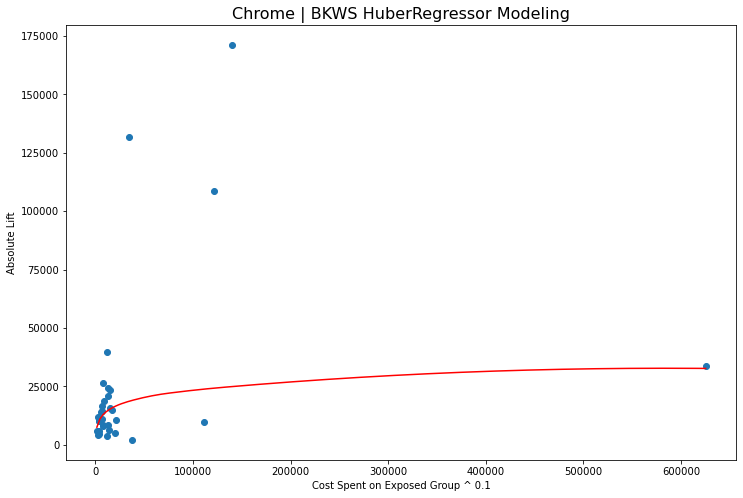

((0.15999999999999998, 36468.56726311849),
 (0.15999999999999998, 0.07430097559503146))

In [98]:
#Separating BKWS Chrome Tactic 
Chrome_BKWS = Chrome.loc[Chrome['tactic_v2'] == "BKWS"]

#ROBUST REGRESSION
Hubor_Regressor(dataset = Chrome_BKWS, powers = powers,  pa_split = 'Chrome | BKWS')

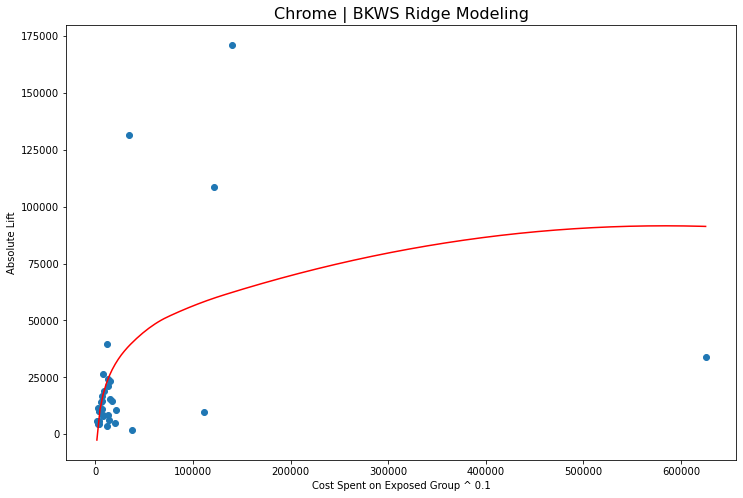

((0.1, 32164.113859377376), (0.1, 0.2799285623331771))

In [99]:
#RIDGE REGRESSION

ridge_regression(dataset = Chrome_BKWS, powers = powers, pa_split = "Chrome | BKWS", alpha = 0.1)

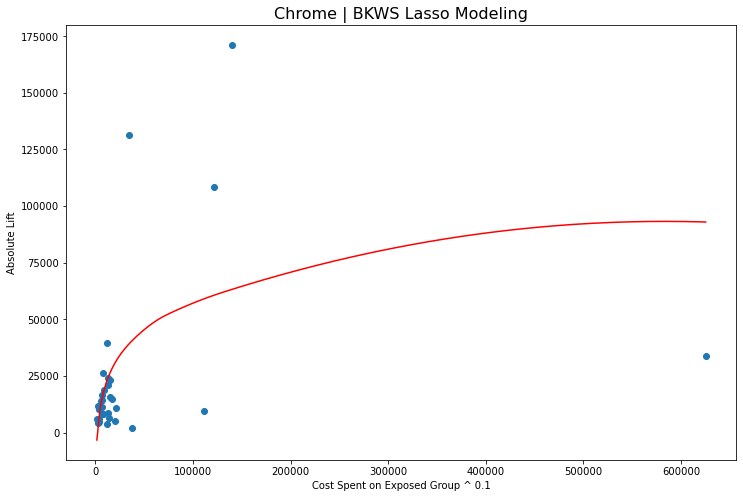

((0.1, 32160.491717001423), (0.1, 0.28009073402669726))

In [100]:
#LASSO REGRESSION

lasso_regression(dataset = Chrome_BKWS, powers = powers, pa_split = "Chrome | BKWS", alpha = 0.1)

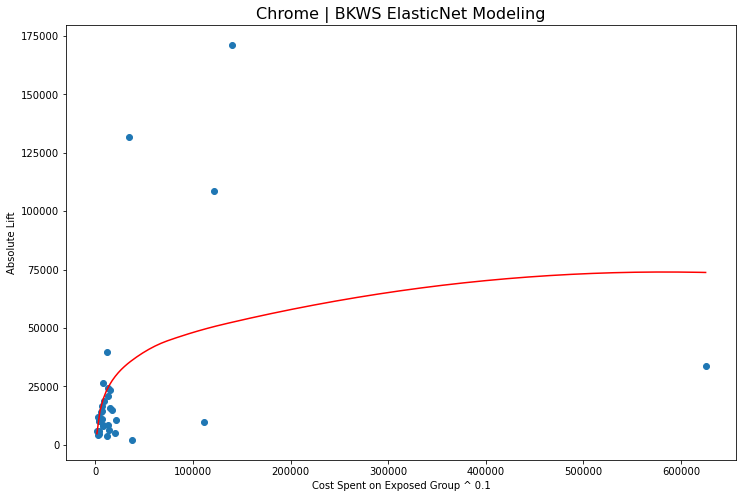

((0.13999999999999999, 32304.620112766042),
 (0.13999999999999999, 0.27362367691964684))

In [101]:
#ELASTICNET REGRESSION

elastic_net(dataset = Chrome_BKWS, powers = powers, pa_split = "Chrome | BKWS", alpha = 0.1)

### Chrome | AO Tactic

In [103]:
#Separating AP Chrome Tactic
Chrome_AO_Tactic = Chrome.loc[Chrome['tactic_v2'] != "BKWS"]

#ROBUST REGRESSION
Hubor_Regressor(dataset = Chrome_AO_Tactic, powers = powers,  pa_split = 'Chrome | AO Tactic')

ValueError: HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL_TERMINATION_IN_LNSRCH

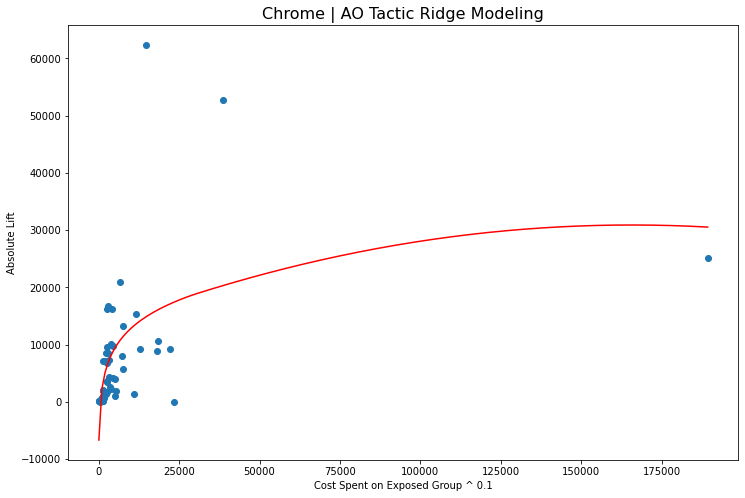

((0.17999999999999997, 9397.093528044512),
 (0.17999999999999997, 0.31892350117373236))

In [104]:
#RIDGE REGRESSION

ridge_regression(dataset = Chrome_AO_Tactic, powers = powers, pa_split = "Chrome | AO Tactic", alpha = 0.1)

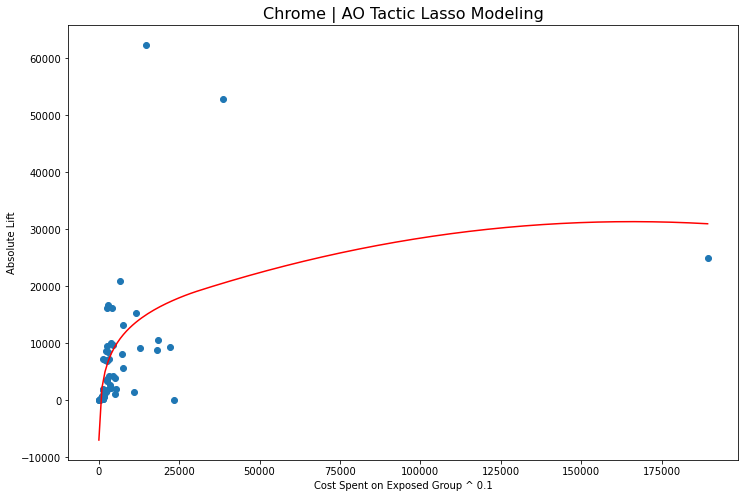

((0.17999999999999997, 9397.088447884902),
 (0.17999999999999997, 0.3189242375666127))

In [105]:
#LASSO REGRESSION

lasso_regression(dataset = Chrome_AO_Tactic, powers = powers, pa_split = "Chrome | AO Tactic", alpha = 0.1)

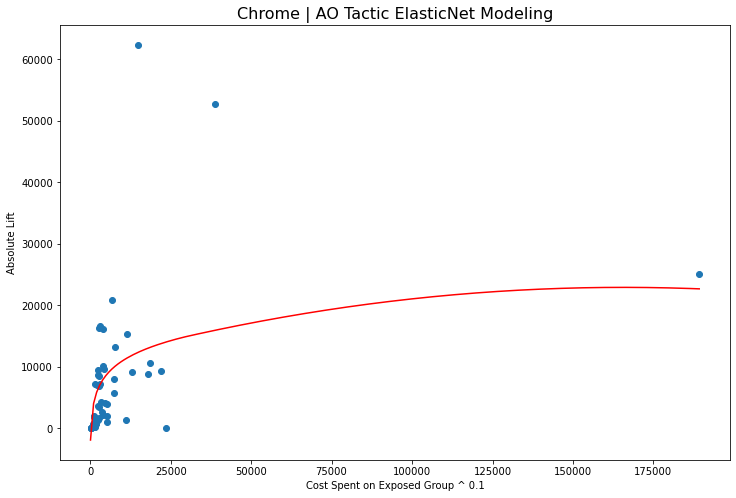

((0.18999999999999995, 9399.208726982111),
 (0.18999999999999995, 0.31861685861096534))

In [106]:
#ELASTICNET REGRESSION

elastic_net(dataset = Chrome_AO_Tactic, powers = powers, pa_split = "Chrome | AO Tactic", alpha = 0.1)

## Non-Chrome 

In [107]:
# Separating out non search cloud data and search data 
Non_Search_Cloud = Final_Data.loc[(Final_Data['pa'] == "Cloud") & (Final_Data['channel'] != "Search")]
print(len(Non_Search_Cloud))
 
Search_Cloud = Final_Data.loc[(Final_Data['pa'] == "Google Cloud") & (Final_Data['channel'] == "Search") & (Final_Data['tactic'] != "All")]
print(len(Search_Cloud))


6
31


### Google Cloud Search & Non-Search | All Tactic

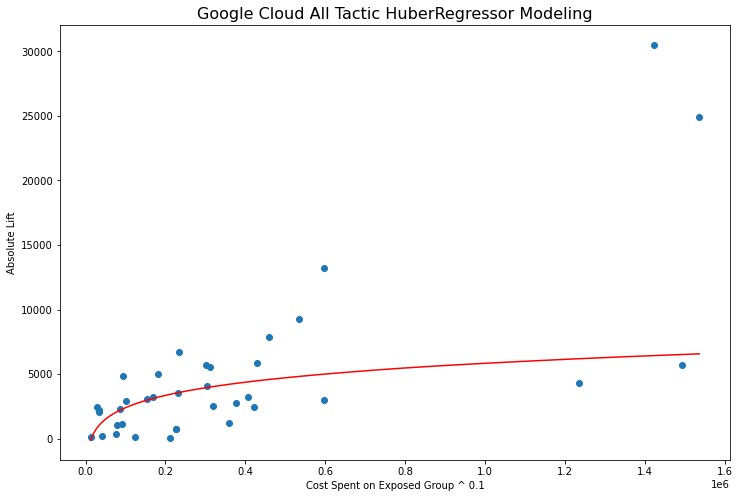

((0.8899999999999996, 4219.9329269223035),
 (0.8899999999999996, 0.5327666515083935))

In [86]:
#combining dataframes together 
Cloud_dataframes = [Non_Search_Cloud, Search_Cloud]
Cloud_data = pd.concat(Cloud_dataframes)

#ROBUST REGRESSION
Hubor_Regressor(dataset = Cloud_data, powers = powers,  pa_split = 'Google Cloud All Tactic')

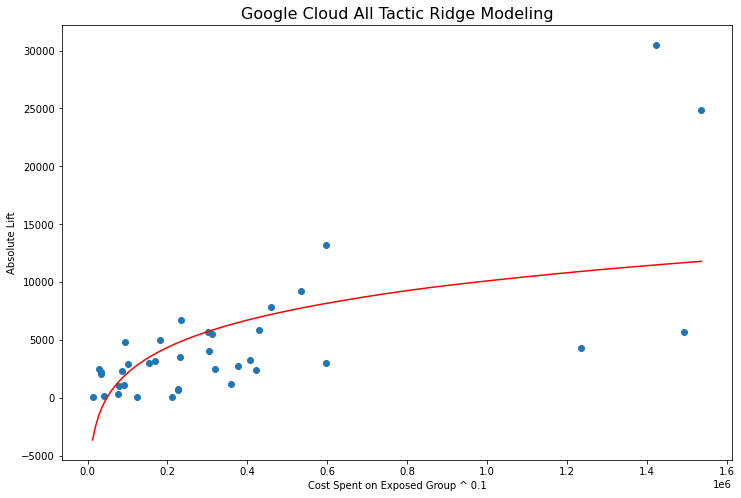

((0.8899999999999996, 4207.94065381124),
 (0.8899999999999996, 0.5354184606253077))

In [87]:
#RIDGE REGRESSION

ridge_regression(dataset = Cloud_data, powers = powers, pa_split = "Google Cloud All Tactic", alpha = 0.1)

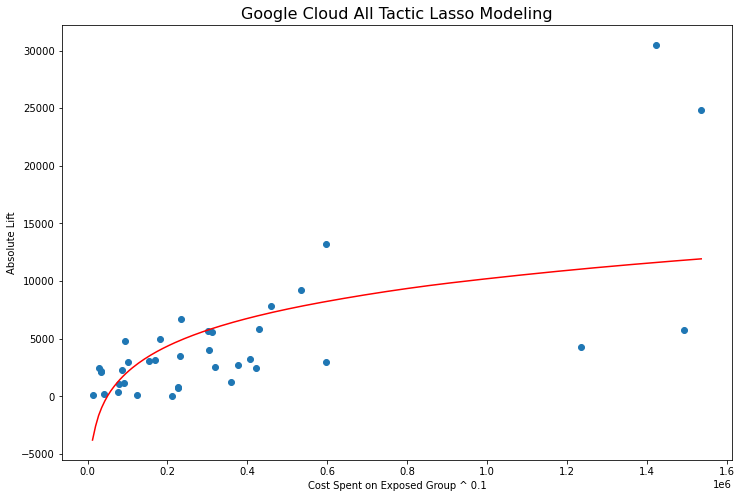

((0.8899999999999996, 4207.94065381124),
 (0.8899999999999996, 0.5354184606253077))

In [88]:
#LASSO REGRESSION

lasso_regression(dataset = Cloud_data, powers = powers, pa_split = "Google Cloud All Tactic", alpha = 0.1)

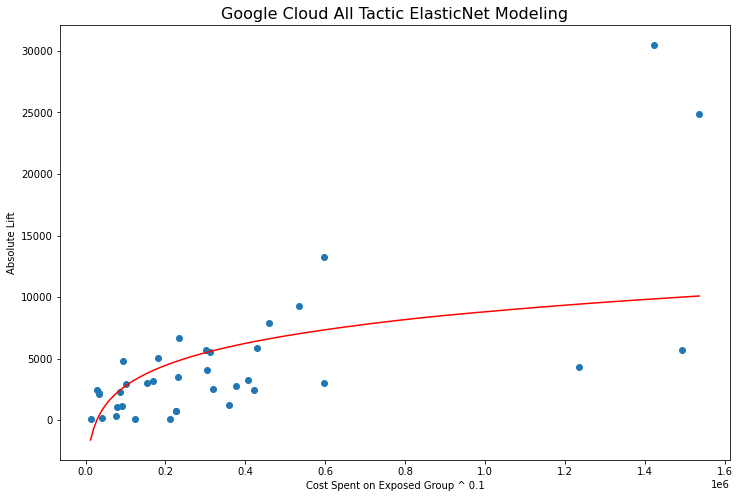

((0.8899999999999996, 4207.94065381124),
 (0.8899999999999996, 0.5354184606253077))

In [89]:
#ELASTICNET REGRESSION

elastic_net(dataset = Cloud_data, powers = powers, pa_split = "Google Cloud All Tactic", alpha = 0.1)

### Google Cloud | BKWS Tactic

In [ ]:
#WIP

### Google Cloud | AO Tactic 

In [ ]:
#WIP

###  Chromebook | All Tactic

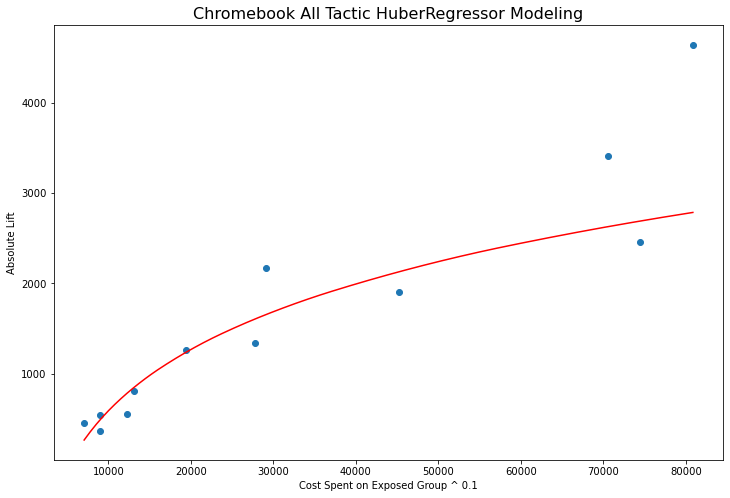

((0.7899999999999996, 458.3165014921914),
 (0.7899999999999996, 0.8707608936563771))

In [90]:
Chromebook = Non_Chrome.loc[Non_Chrome['pa'] == "Chromebook"]

#ROBUST REGRESSION
Hubor_Regressor(dataset = Chromebook, powers = powers,  pa_split = 'Chromebook All Tactic')

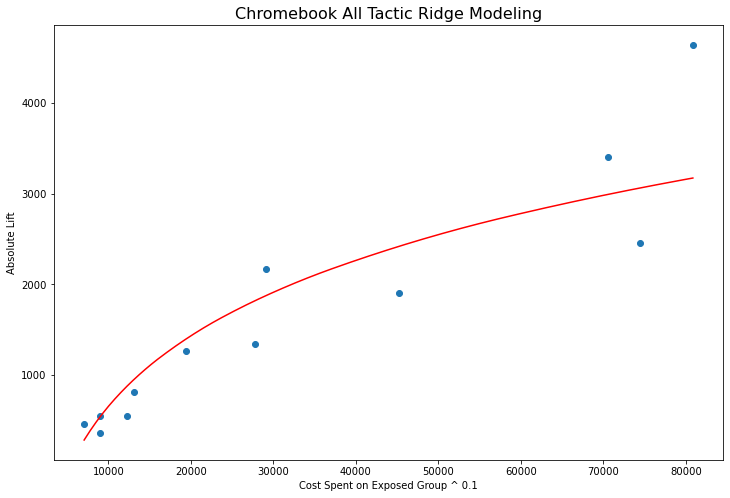

((0.8599999999999995, 457.88633180080836),
 (0.8599999999999995, 0.8710033839706889))

In [91]:
#RIDGE REGRESSION

ridge_regression(dataset = Chromebook, powers = powers, pa_split = "Chromebook All Tactic", alpha = 0.1)

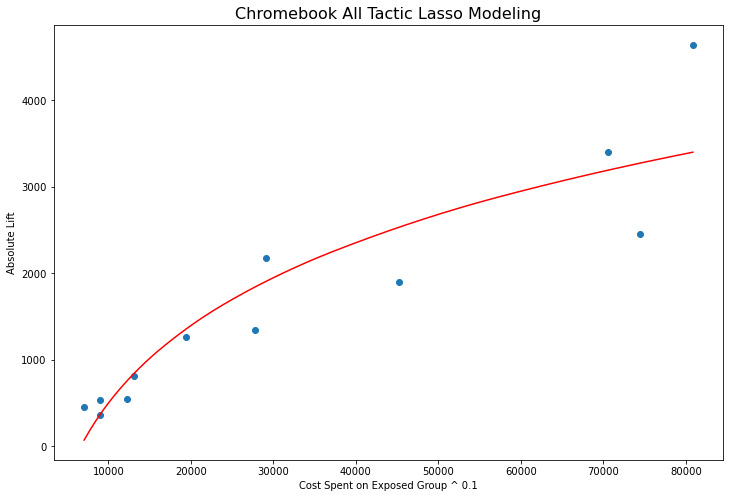

((0.8599999999999995, 457.88633180080876),
 (0.8599999999999995, 0.8710033839706887))

In [92]:
#LASSO REGRESSION

lasso_regression(dataset = Chromebook, powers = powers, pa_split = "Chromebook All Tactic", alpha = 0.1)

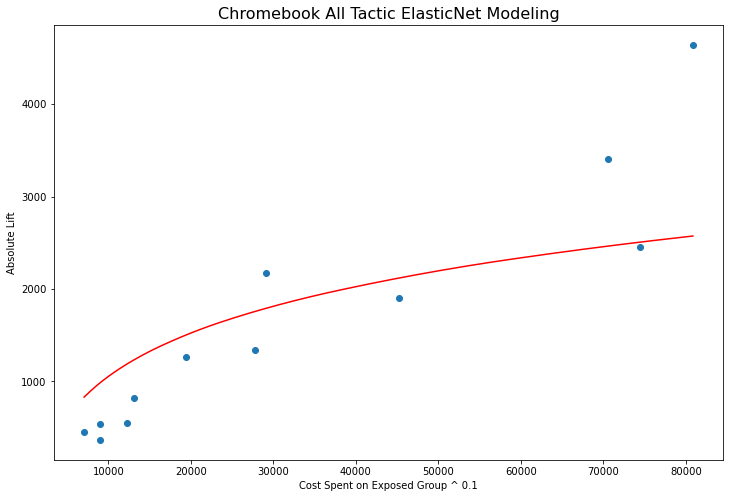

((0.8599999999999995, 457.8863318008085),
 (0.8599999999999995, 0.8710033839706888))

In [93]:
#ELASTICNET REGRESSION

elastic_net(dataset = Chromebook, powers = powers, pa_split = "Chromebook All Tactic", alpha = 0.1)

### Chromebook | BKWS Tactic

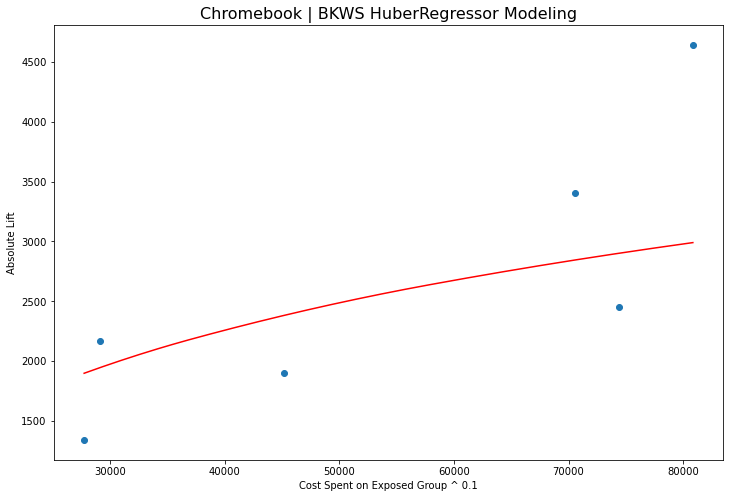

((0.8399999999999996, 635.6528600239632),
 (0.8399999999999996, 0.6577480392718913))

In [108]:
Chromebook_BKWS = Non_Chrome.loc[(Non_Chrome['tactic_v2'] == "BKWS") & (Non_Chrome['pa'] == "Chromebook")]

#ROBUST REGRESSION
Hubor_Regressor(dataset = Chromebook_BKWS, powers = powers,  pa_split = 'Chromebook | BKWS')

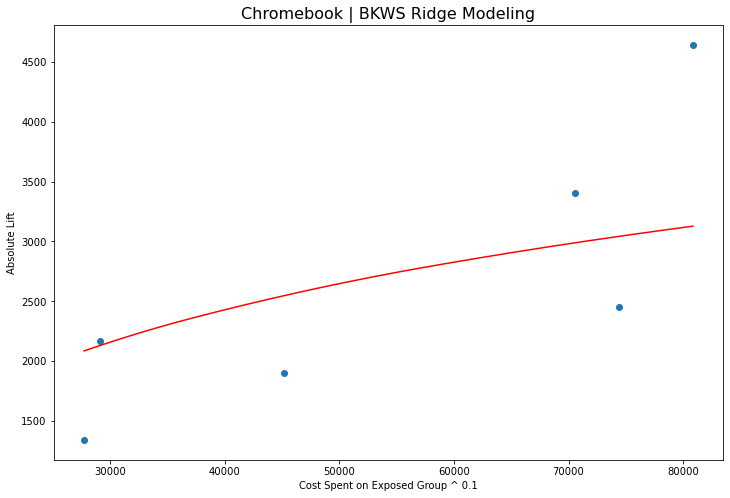

((0.8899999999999996, 632.2386076936629),
 (0.8899999999999996, 0.6614148089205236))

In [109]:
#RIDGE REGRESSION

ridge_regression(dataset = Chromebook_BKWS, powers = powers, pa_split = "Chromebook | BKWS", alpha = 0.1)

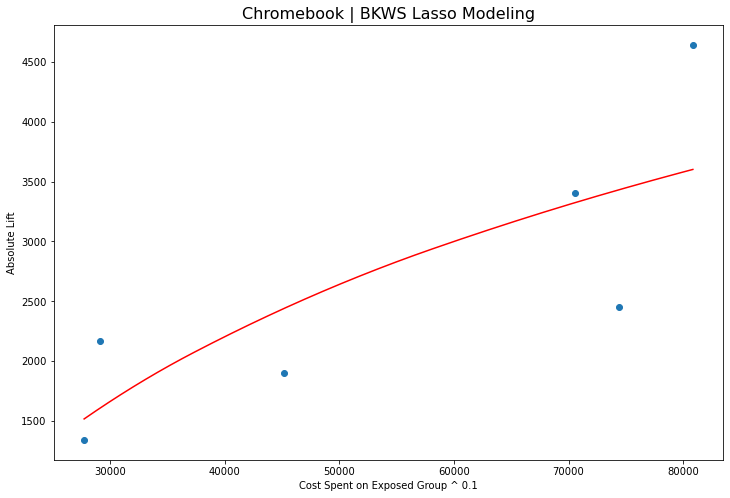

((0.8899999999999996, 632.2386076936632),
 (0.8899999999999996, 0.6614148089205234))

In [110]:
#LASSO REGRESSION

lasso_regression(dataset = Chromebook_BKWS, powers = powers, pa_split = "Chromebook | BKWS", alpha = 0.1)

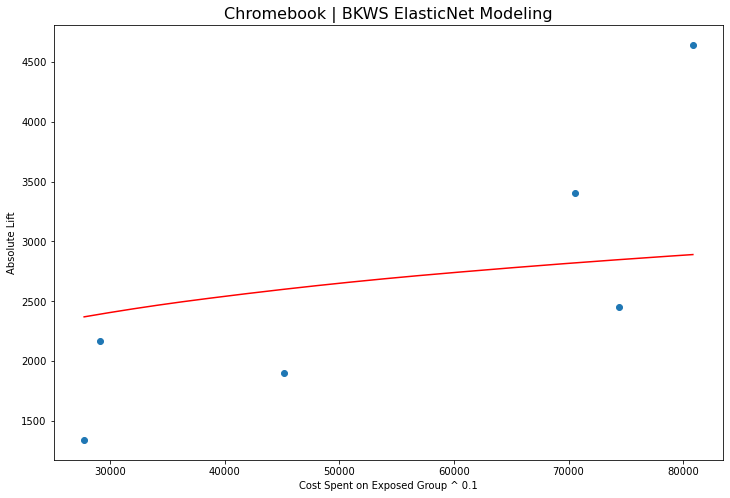

((0.8899999999999996, 632.238607693663),
 (0.8899999999999996, 0.6614148089205236))

In [111]:
#ELASTICNET REGRESSION

elastic_net(dataset = Chromebook_BKWS, powers = powers, pa_split = "Chromebook | BKWS", alpha = 0.1)

### Chromebook | AO Tactic 

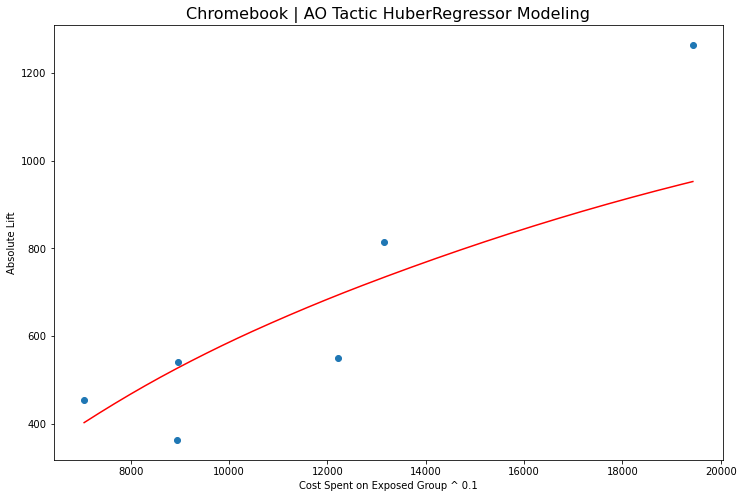

((0.8899999999999996, 102.31904703849025),
 (0.8899999999999996, 0.8848939504859143))

In [113]:
Chromebook_AO_Tactic = Non_Chrome.loc[(Non_Chrome['tactic_v2'] != "BKWS") & (Non_Chrome['pa'] == "Chromebook")]

#ROBUST REGRESSION
Hubor_Regressor(dataset = Chromebook_AO_Tactic, powers = powers,  pa_split = 'Chromebook | AO Tactic')

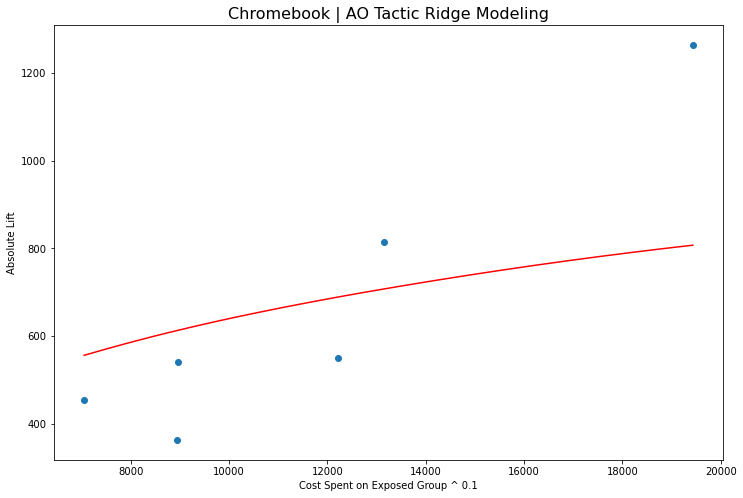

((0.8899999999999996, 101.08435940791338),
 (0.8899999999999996, 0.8876551672085456))

In [114]:
#RIDGE REGRESSION

ridge_regression(dataset = Chromebook_AO_Tactic, powers = powers, pa_split = "Chromebook | AO Tactic", alpha = 0.1)

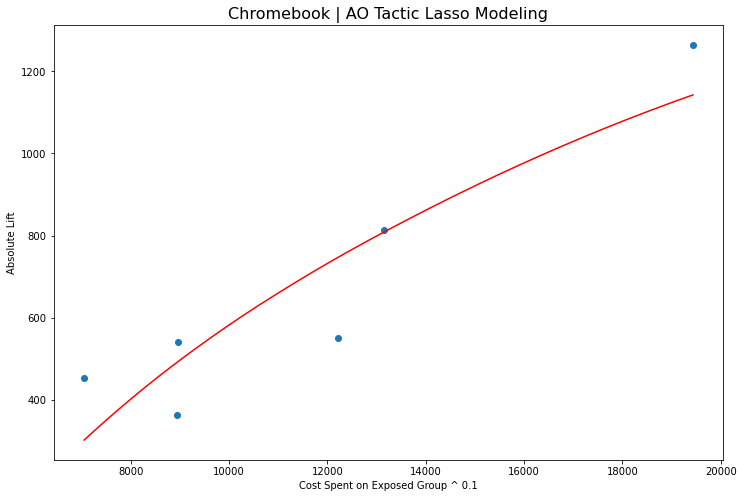

((0.8899999999999996, 101.08435940794375),
 (0.8899999999999996, 0.8876551672084783))

In [115]:
#LASSO REGRESSION

lasso_regression(dataset = Chromebook_AO_Tactic, powers = powers, pa_split = "Chromebook | AO Tactic", alpha = 0.1)

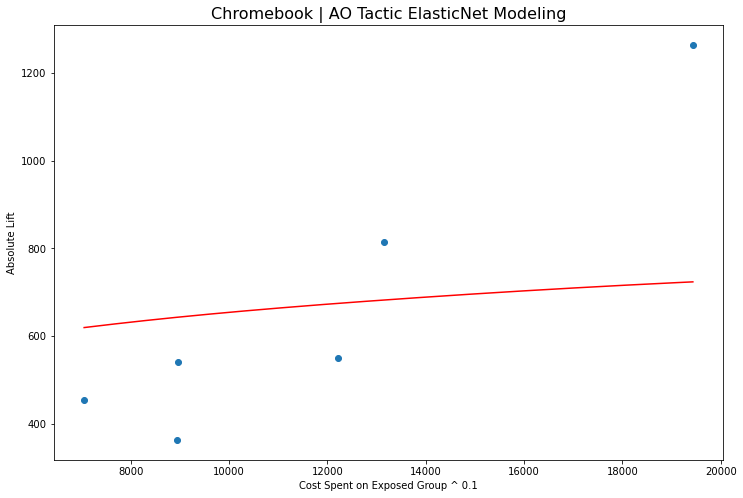

((0.8899999999999996, 101.0843594079247),
 (0.8899999999999996, 0.8876551672085206))

In [116]:
#ELASTICNET REGRESSION

elastic_net(dataset = Chromebook_AO_Tactic, powers = powers, pa_split = "Chromebook | AO Tactic", alpha = 0.1)

### DSM & Pixel | All Tactic 

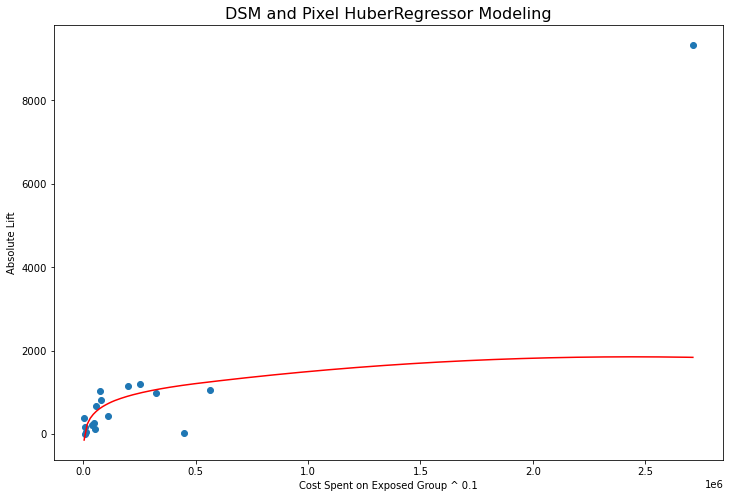

((0.8899999999999996, 604.3054309375392),
 (0.8899999999999996, 0.918186672553361))

In [94]:
DSM_Pixel = Non_Chrome.loc[Non_Chrome['pa'].isin(["DSM","Pixel"])]

Hubor_Regressor(dataset = DSM_Pixel, powers = powers,  pa_split = 'DSM and Pixel')

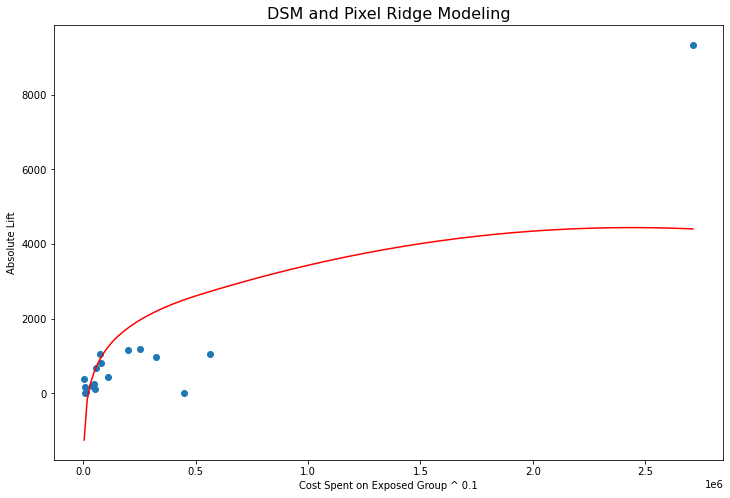

((0.8899999999999996, 587.1251562874113),
 (0.8899999999999996, 0.9227724176403826))

In [95]:
ridge_regression(dataset = DSM_Pixel, powers = powers, pa_split = "DSM and Pixel", alpha = 0.1)

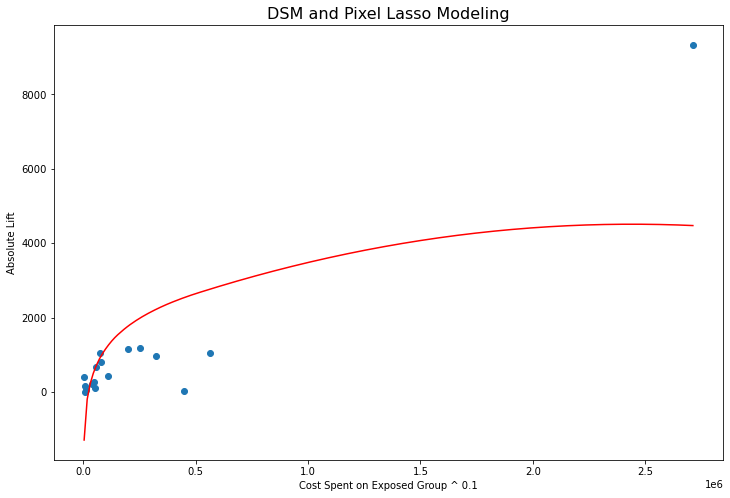

((0.8899999999999996, 587.1251562874114),
 (0.8899999999999996, 0.9227724176403825))

In [96]:
lasso_regression(dataset = DSM_Pixel, powers = powers, pa_split = "DSM and Pixel", alpha = 0.1)

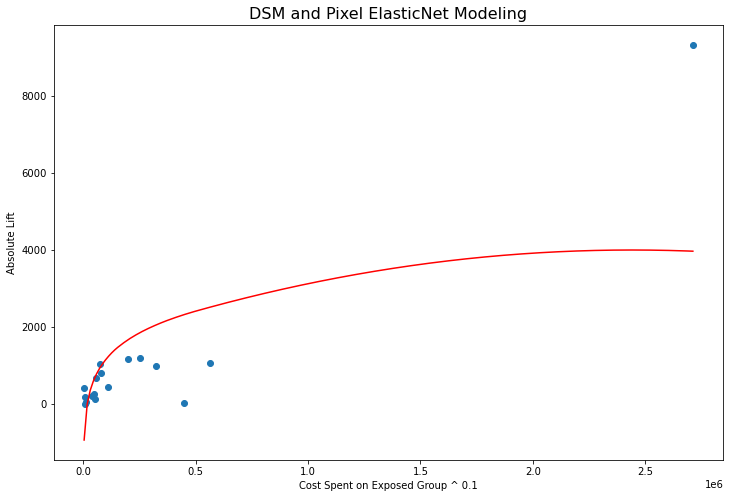

((0.8899999999999996, 587.1251562874113),
 (0.8899999999999996, 0.9227724176403826))

In [97]:
elastic_net(dataset = DSM_Pixel, powers = powers, pa_split = "DSM and Pixel", alpha = 0.1)

### DSM & Pixel | BKWS Tactic

In [117]:
DSM_Pixel_BKWS = Non_Chrome.loc[(Non_Chrome['tactic_v2'] == "BKWS") & (Non_Chrome['pa'].isin(["DSM", "Pixel"]))]

#ROBUST REGRESSION
Hubor_Regressor(dataset = DSM_Pixel_BKWS, powers = powers,  pa_split = 'DSM and Pixel | BKWS')

C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ValueError: HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL_TERMINATION_IN_LNSRCH

In [118]:
#RIDGE REGRESSION

ridge_regression(dataset = DSM_Pixel_BKWS, powers = powers, pa_split = "DSM and Pixel | BKWS", alpha = 0.1)

ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [119]:
#LASSO REGRESSION

lasso_regression(dataset = DSM_Pixel_BKWS, powers = powers, pa_split = "DSM and Pixel | BKWS", alpha = 0.1)

ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [ ]:
#ELASTICNET REGRESSION

elastic_net(dataset = DSM_Pixel_BKWS, powers = powers, pa_split = "DSM and Pixel | BKWS", alpha = 0.1)

### DSM & Pixel | AO Tactic 

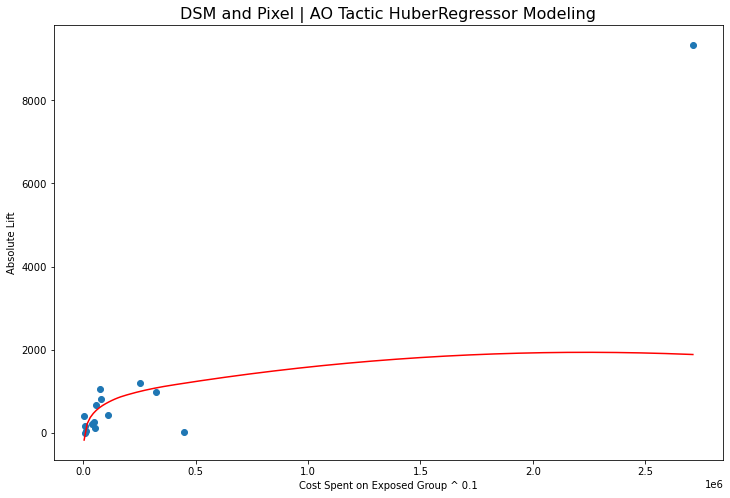

((0.8899999999999996, 555.3431404183897),
 (0.8899999999999996, 0.9390256905395561))

In [120]:
DSM_Pixel_AO_Tactic = Non_Chrome.loc[(Non_Chrome['tactic_v2'] != "BKWS") & (Non_Chrome['pa'].isin(["DSM", "Pixel"]))]

#ROBUST REGRESSION
Hubor_Regressor(dataset = DSM_Pixel_AO_Tactic, powers = powers,  pa_split = 'DSM and Pixel | AO Tactic')

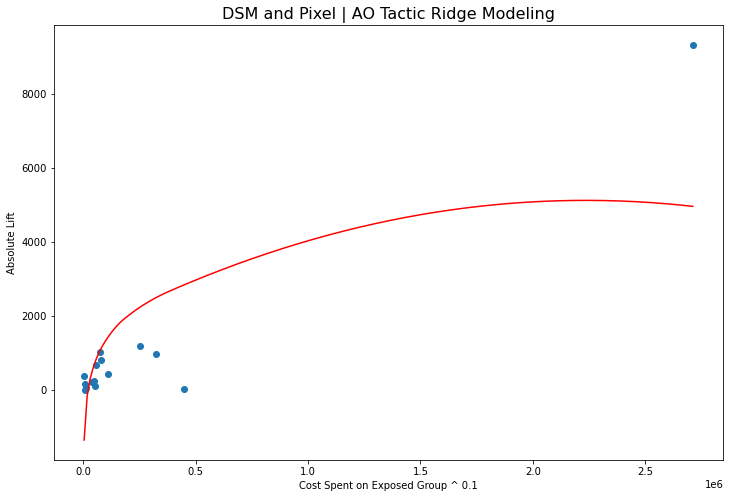

((0.8899999999999996, 547.0474728246601),
 (0.8899999999999996, 0.9408337425328117))

In [121]:
#RIDGE REGRESSION

ridge_regression(dataset = DSM_Pixel_AO_Tactic, powers = powers, pa_split = "DSM and Pixel | AO Tactic", alpha = 0.1)

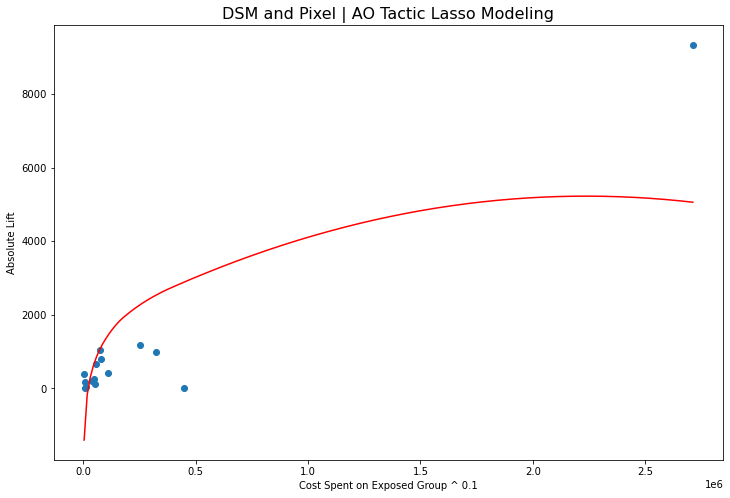

((0.8899999999999996, 547.0474728246601),
 (0.8899999999999996, 0.9408337425328117))

In [122]:
#LASSO REGRESSION

lasso_regression(dataset = DSM_Pixel_AO_Tactic, powers = powers, pa_split = "DSM and Pixel | AO Tactic", alpha = 0.1)

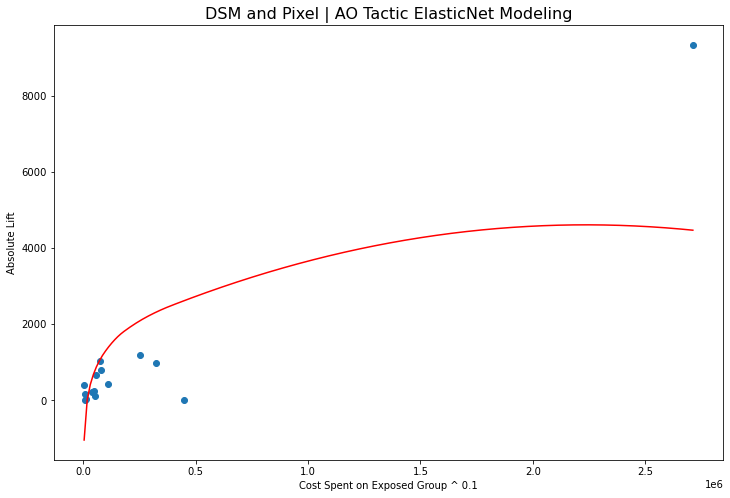

((0.8899999999999996, 547.0474728246601),
 (0.8899999999999996, 0.9408337425328117))

In [123]:
#ELASTICNET REGRESSION

elastic_net(dataset = DSM_Pixel_AO_Tactic, powers = powers, pa_split = "DSM and Pixel | AO Tactic", alpha = 0.1)